# Sesión 3: Modelos que aprenden cómo se mueven las moléculas

En esta sesión vamos a utilizar `OpenMM` para simular la dinámica del plegamiento de un peptido, AceAla15Nme, en vacio y su analysis con `MDAnalysis`. Posteriormente, vamos a analizar la dinámica de un receptor de membrana,el receptor de 5-hydroxitriptamina 2A, unida a un antipsicótico, el resperidon, comparandolo con su apoforma (sin ligando).

## 0. Installación de paquetes
Vamos a instalar los paquetes que necesitamos

In [ ]:
# @title Instalar paquetes
!pip install openmm
!pip install ipywidgets==7.7.2
!pip install jupyterlab-widgets==1.1.1
!pip install nglview==2.7 # para su Visualizacion
!pip install notebook==6.4.12
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!jupyter nbextension enable nglview --py --sys-prefix
!pip install MDAnalysis
!pip install matplotlib
!pip install seaborn

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


## 1. Plegamiento de péptido de Alanina

En este caso, utilizaremos una cadena de 15 Alaninas con un grupo acetil en el N-terminal y un grupo N-Me en el C-terminal. La estructura ha sido preparada previamente por mí y se encuentra en el github.

Vamos a descargar la estructura y visualizarla:

In [ ]:
!wget https://raw.githubusercontent.com/RaulFD-creator/BiotechWorkshopAI/refs/heads/main/Archivos/Ala15.pdb



import nglview as nv
import ipywidgets
from nglview.adaptor import FileStructure

# Cargar el archivo PDB
pdb = FileStructure('/content/Ala15.pdb')
view = nv.NGLWidget(pdb)

# Añadir representaciones
view.add_representation('cartoon', selection='protein')
view.add_representation('ball+stick', selection='protein')


# Mostrar la visualización
view

El siguiente paso es cargar los paquetes necesarios de `OpenMM` y crear el systema.

In [ ]:
from openmm import *
from openmm.app import *
from openmm.unit import *


# Primero cargamos el archivo PDB
pdb = PDBFile('Ala15.pdb')

# Vamos a cargar el ForceField. En OpenMM, por defecto tenemos Amber, AMOEBA y CHARMM.
# Va a ser interesante que probemos varios para ver si hay diferencias en los resultados.
forcefield = ForceField('amber14-all.xml') # charmm36.xml, amoeba2018.xml, amber99sbildn.xml

# Definimos la caja de simulación. Se podría hacer en el vacío, pero vamos a definir una caja enorme para que no haya interacciones con las moléculas vecinas.
# En este caso, vamos a definir una caja de 1000x1000x1000 nm.
a = Vec3(999.99 * nanometer, 0 * nanometer, 0 * nanometer)
b = Vec3(0 * nanometer, 999.99 * nanometer, 0 * nanometer)
c = Vec3(0 * nanometer, 0 * nanometer, 999.99 * nanometer)
pdb.box_vectors = (a, b, c)

# Vamos a cargar la configuración inicial del systema
nonbondedMethod = NoCutoff # Todos los atomos ven a todos los demás
constraints = HBonds # Vamos a mantener los enlaces de hidrógeno fijos, pero no los enlaces de la cadena principal.
constraintTolerance = 1e-5 # Tolerancia de las restricciones
friction = 1/picosecond # Coeficiente de fricción para el termostato
dt = 0.002*picoseconds # Paso de tiempo de la simulación
temperature = 300*kelvin # Temperatura de la simulación

steps = 500000 # Número de pasos de la simulación
xtcReporter = DCDReporter('prod.dcd', 100) # Guardamos la trayectoria cada 1000 pasos. Es decir cada 0.2 ps.

print('Creando el sistema...')
topology = pdb.topology
positions = pdb.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod,
    constraints=constraints) # Creamos el sistema
system.setDefaultPeriodicBoxVectors(a, b, c) # Definimos la caja de simulación

integrator = LangevinMiddleIntegrator(300, friction, dt) # Definimos el integrador
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(positions) # Definimos la configuración inicial
simulation.context.setVelocitiesToTemperature(temperature) # Asignamos velocidades iniciales

Ahora vamos a minimizar la energia del sistema. Este paso se realiza para evitar que la configuración inicial este tan alejada que pueda provocar problemas. Se ajusta los angulos y longitud de los enlaces.

In [ ]:
print('Minimizando el sistema...')
simulation.minimizeEnergy() # Minimizamos la energía

Finalmente, simulamos el sistema durante 1 ns. Es suficiente para ver el plegamiento del péptido. Esto puede tardar, asi que paciencia.

In [ ]:
print('Simulando...')

simulation.reporters.append(xtcReporter)
simulation.reporters.append(StateDataReporter('ala.log', 1000, progress=True, step=True, time=True,
                                               potentialEnergy=True, kineticEnergy=True, totalEnergy=True,
                                               volume=True, density=True, remainingTime=True, speed=True,
                                               elapsedTime=True, temperature=True, totalSteps=500000, separator=' ')) # Guardamos los datos de la simulación
simulation.step(steps) # Simulamos

In [ ]:
!pip install py3dmol

In [ ]:
import py3Dmol

In [ ]:
def visualize_mda_universe(u, \
    sel_string='not ((resname WAT) or (resname HOH))',
    style={"stick": {'color': 'spectrum'}},
    stride_animation=None):
  """
  Inputs:
  u : mdanalysis universe
  sel_string : mdanalysis selection string for visible atoms
  style : py3Dmol style
  """
  # The number of frames in the simulation
  number_frames_analysis = len(u.trajectory)
  if number_frames_analysis > 10 and not stride_animation:
    stride_animation = number_frames_analysis/1000
  elif not stride_animation:
    stride_animation = 1

  # Deleting previously stored frames as PDBs and removing warnings
  import warnings
  warnings.filterwarnings('ignore')
  !rm [0-9]?.pdb 2> /dev/null

    # Helper classes to read and get PDB fields
  class Atom(dict):
    def __init__(self, line):
      self["type"] = line[0:6].strip()
      self["idx"] = line[6:11].strip()
      self["name"] = line[12:16].strip()
      self["resname"] = line[17:20].strip()
      self["resid"] = int(int(line[22:26]))
      self["x"] = float(line[30:38])
      self["y"] = float(line[38:46])
      self["z"] = float(line[46:54])
      self["sym"] = line[76:78].strip()

    def __str__(self):
      line = list(" " * 80)
      line[0:6] = self["type"].ljust(6)
      line[6:11] = self["idx"].ljust(5)
      line[12:16] = self["name"].ljust(4)
      line[17:20] = self["resname"].ljust(3)
      line[22:26] = str(self["resid"]).ljust(4)
      line[30:38] = str(self["x"]).rjust(8)
      line[38:46] = str(self["y"]).rjust(8)
      line[46:54] = str(self["z"]).rjust(8)
      line[76:78] = self["sym"].rjust(2)
      return "".join(line) + "\n"

  class Molecule(list):
    def __init__(self, file):
      for line in file:
        if "ATOM" in line or "HETATM" in line:
          self.append(Atom(line))

      def __str__(self):
        outstr = ""
        for at in self:
          outstr += str(at)
        return outstr

  # Write out frames for animation
  protein = u.select_atoms(sel_string)
  i = 0
  for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
      if i > -1:
          with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
              W.write(protein)
      i = i + 1
  # Load frames as molecules (py3Dmol let us visualize a single "molecule" per frame)
  molecules = []
  for i in range(int(len(u.trajectory)/int(stride_animation))):
      with open('' + str(i) + '.pdb') as ifile:
          molecules.append(Molecule(ifile))

  models = ""
  for i in range(len(molecules)):
    models += "MODEL " + str(i) + "\n"
    for j,mol in enumerate(molecules[i]):
      models += str(mol)
    models += "ENDMDL\n"

  # Animation
  view = py3Dmol.view(width=800, height=600)
  view.addModelsAsFrames(models)
  for i, at in enumerate(molecules[0]):
      view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", style))

  view.zoomTo()
  view.animate({'loop': "forward", 'reps': 0}) # 0 means infinite loop
  return view

Ahora vamos a visualizar la trayectoria generada.

In [ ]:
import MDAnalysis as mda

# Cargar el archivo de estructura y la trayectoria
traj = mda.Universe('Ala15.pdb', 'prod.dcd')
view = visualize_mda_universe(traj, stride_animation=1)
view

Finalmente, vamos a ver la evolución de la estructura secundaria con el tiempo.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from MDAnalysis.analysis.dssp import DSSP

# Calcular la estructura secundaria
dssp = DSSP(traj).run().results['dssp']
# Definir los tipos de estructura secundaria
ss_types = ['H', 'B', 'E', 'G', 'I', 'T', 'S', '-']
ss_labels = ['Helix', 'Bridge', 'Strand', '3-10 Helix', 'Pi-Helix', 'Turn', 'Bend', 'Coil']

# Contar la frecuencia de cada tipo de estructura secundaria en cada frame
ss_counts = np.array([[np.sum(dssp_frame == ss) for ss in ss_types] for dssp_frame in dssp])

# Plotear la estructura secundaria con respecto al tiempo
plt.figure(figsize=(10, 6))
for i, ss_type in enumerate(ss_types):
    plt.plot(ss_counts[:, i], label=ss_labels[i])

plt.xlabel('Frame')
plt.ylabel('Número')
plt.title('Estructura secundaria')
plt.legend()
plt.show()

In [ ]:
# Función para leer el log de OpenMM
def read_openmm_log(file_path):
    steps = []
    potential_energy = []
    kinetic_energy = []
    total_energy = []
    temperature = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            parts = line.split()
            steps.append(int(parts[1]))  # Paso
            potential_energy.append(float(parts[3]))  # Energía potencial
            kinetic_energy.append(float(parts[4]))  # Energía cinética
            total_energy.append(float(parts[5]))  # Energía total
            temperature.append(float(parts[6]))  # Temperatura

    return steps, potential_energy, kinetic_energy, total_energy, temperature

# Leer el log de OpenMM
log_file = 'ala.log'  # Reemplaza con la ruta a tu archivo de log
steps, potential_energy, kinetic_energy, total_energy, temperature = read_openmm_log(log_file)

# Plotear los datos
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(steps, potential_energy, label='Energía Potencial')
plt.plot(steps, kinetic_energy, label='Energía Cinética')
plt.plot(steps, total_energy, label='Energía Total')
plt.xlabel('Paso')
plt.ylabel('Energía (kJ/mol)')
plt.title('Energía a lo largo de la simulación')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(steps, temperature, label='Temperatura', color='red')
plt.xlabel('Paso')
plt.ylabel('Temperatura (K)')
plt.title('Temperatura a lo largo de la simulación')
plt.legend()

plt.tight_layout()
plt.show()

## 2. Análisis de un antipsicótico

El grupo de la Prof. Jana Selent, de el IMIM y la Universidad Pompeu Fabra, donde hice mi Máster, esta especializado en estudiar perfiles farmacologicos en GPCRs, especificamente antisicóticos.

Hoy, vamos a descargar y analizar una de sus simulaciones, 848 y 849, desde __[gpcrmd.org](http://gpcrmd.org)__, la web que hostean. Se trata de la simulación de una GPCR, incluyendo una membrana, agua e iones, con y sin el antipsicótico Risperidon.

In [ ]:
!wget https://gpcrmd.org/dynadb/files/Dynamics/16104_dyn_848.psf -O apoform.psf
!wget https://gpcrmd.org/dynadb/files/Dynamics/16105_trj_848.xtc -O apoform.xtc
!wget https://gpcrmd.org/dynadb/files/Dynamics/16111_dyn_849.psf -O ligand.psf
!wget https://gpcrmd.org/dynadb/files/Dynamics/16112_trj_849.xtc -O ligand.xtc


--2025-03-27 09:23:33--  https://gpcrmd.org/dynadb/files/Dynamics/16104_dyn_848.psf
Resolving gpcrmd.org (gpcrmd.org)... 84.89.134.156
Connecting to gpcrmd.org (gpcrmd.org)|84.89.134.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12628145 (12M) [chemical/x-charmm-psf]
Saving to: ‘apoform.psf’

apoform.psf         100%[===================>]  12.04M   556KB/s    in 24s     

2025-03-27 09:23:58 (514 KB/s) - ‘apoform.psf’ saved [12628145/12628145]

--2025-03-27 09:23:58--  https://gpcrmd.org/dynadb/files/Dynamics/16105_trj_848.xtc
Resolving gpcrmd.org (gpcrmd.org)... 84.89.134.156
Connecting to gpcrmd.org (gpcrmd.org)|84.89.134.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769450456 (734M)
Saving to: ‘apoform.xtc’

apoform.xtc          18%[==>                 ] 137.59M   517KB/s    eta 19m 52s

In [ ]:
# Cargar el archivo de estructura y la trayectoria
traj = mda.Universe('ligand.psf', 'ligand.xtc')
view = visualize_mda_universe(traj, stride_animation=1000)
view

Vamos a analizar las interacciones ligando proteina utilizando `MDAnalysis`.

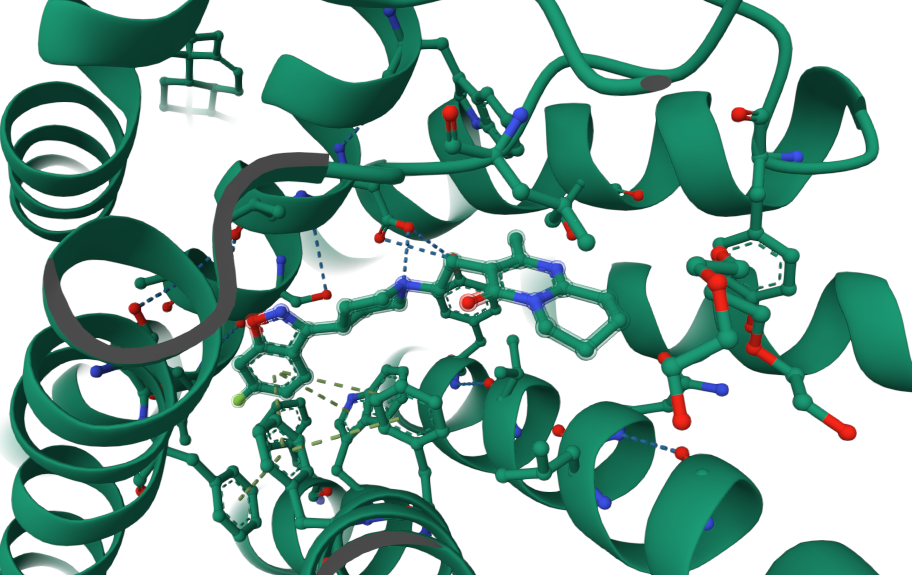


Obtenida del cristal PDBid:6A93

In [ ]:
from MDAnalysis.analysis import contacts

sel_ligand = "resname 8NU and not name C* H*"
sel_protein = "protein and  not name C* H*"

ligand = traj.select_atoms(sel_ligand)
protein = traj.select_atoms(sel_protein)

def contacts_within_cutoff(u, group_a, group_b, radius=4.5):
    timeseries = []
    for ts in u.trajectory:
        # Calcular distancias entre los átomos de los grupos
        dist = contacts.distance_array(group_a.positions, group_b.positions)
        # determinar si hay contacto dentro del radio de corte
        n_contacts = contacts.contact_matrix(dist, radius).sum()
        timeseries.append([ts.frame, n_contacts])
    return np.array(timeseries)

ca = contacts_within_cutoff(traj, ligand, protein, radius=3.5)

plt.figure(figsize=(12, 6))
plt.plot(ca[:, 0], ca[:, 1])
plt.xlabel('Frame')
plt.ylabel('Número de contactos')
plt.title('Contactos entre el ligando y la proteína')

Ahora vamos a analyzar el contacto con el puente de hidrogeno entre el residuo ASP155 y el ligando

In [ ]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA


hbonds = HBA(universe=traj, hydrogens_sel="resname 8NU and name H06", acceptors_sel='resname ASP and resid 155 and name OD1 OD2')
hbonds.run()

plt.figure(figsize=(12, 6))
plt.plot(range(len(hbonds.count_by_time())), hbonds.count_by_time())
plt.xlabel('Frame')
plt.ylabel('Número de puentes de hidrógeno')
plt.title('Puente de hydrogeno ASP155-8NU')

Finalmente vamos a analizar el RMSD (root mean square deviation) del ligando a lo largo de la trayectoria.

In [ ]:
from MDAnalysis.analysis import rms

# Seleccionar el ligando
ligand = traj.select_atoms('resname 8NU')

# Calcular el RMSD del ligando a lo largo de la trayectoria
R = rms.RMSD(ligand, select='resname 8NU')
R.run()

# Obtener los resultados del RMSD
rmsd = R.rmsd.T

# Plotear el RMSD del ligando a lo largo de la trayectoria
plt.figure(figsize=(10, 6))
plt.plot(range(len(rmsd[1])), rmsd[2], label='Ligando RMSD')
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.title('RMSD del ligando a lo largo de la simulación')
plt.legend()
plt.show()

Ahora vamos a comparar las distancias entre la TM6 y TM2, que indica el grado de activación de la GPCR.

In [ ]:


apo = mda.Universe('apoform.psf', 'apoform.xtc')

# Seleccionar el residuo de interés SER314 (TM6) y PHE112 (TM2)
ser314_apo = apo.select_atoms('resid 314 and protein')
phe112_apo = apo.select_atoms('resid 112 and protein')
ser314_lig = traj.select_atoms('resid 314 and protein')
phe112_lig = traj.select_atoms('resid 112 and protein')

# Calcular la distancia entre los residuos de interés
distances_apo = []
distances_lig = []
for ts in apo.trajectory:
    distances_apo.append(np.linalg.norm((ser314_apo.center_of_mass() - phe112_apo.center_of_mass())))
for ts in traj.trajectory:
    distances_lig.append(np.linalg.norm((ser314_lig.center_of_mass() - phe112_lig.center_of_mass())))

# Plotear la distancia entre los residuos de interés
plt.figure(figsize=(12, 6))
plt.plot(range(len(distances_apo)), distances_apo, label='Apo')
plt.plot(range(len(distances_lig)), distances_lig, label='Ligando')
plt.xlabel('Frame')
plt.ylabel('Distancia (Å)')
plt.title('Distancia entre SER314 y PHE112')
plt.legend()